# ** Intel Image Classification **

We'll work with the [Intel Image Classification dataset](https://www.kaggle.com/puneet6060/intel-image-classification/version/2) from Kaggle.

This is image data of natural scenes around the world. It contains around 25k images of size 150x150 distributed under 6 categories.
The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

In [ ]:
import os
import pathlib

from tqdm import tqdm
import cv2          

import numpy as np            
from sklearn.utils import shuffle 
from sklearn.metrics import confusion_matrix    
import pandas as pd
import matplotlib.pyplot as plt   
import seaborn as sn; sn.set(font_scale=1.4) 

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomBrightness, RandomContrast, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Activation, Dropout, MaxPool2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

# Set the random seed
tf.random.set_seed(42)

# Import and preprocess the data

## Import the data

**Note:** If you're using Google Colab and your runtime disconnects, you may have to redownload the files. You can do this by rerunning the cells above.

In [ ]:
! mkdir ~/.kaggle # create the .kaggle folder in the root directory
! echo '{"username":"panagiotis427","key":"62e7ce1d44b49db295f005495a3e0ebc"}' > ~/.kaggle/kaggle.json # write kaggle API credentials to kaggle.json
! chmod 600 ~/.kaggle/kaggle.json  # set permissions
! pip install kaggle # install the kaggle library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download -d puneet6060/intel-image-classification -p /content/kaggle/

 99% 342M/346M [00:06<00:00, 55.2MB/s]
100% 346M/346M [00:06<00:00, 52.8MB/s]


In [ ]:
%cd kaggle
! unzip intel-image-classification

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/769

## Overview the data structure

`ls` stands for list.

In [ ]:
!ls 

intel-image-classification.zip	seg_pred  seg_test  seg_train


In [ ]:
!ls seg_train/seg_train

buildings  forest  glacier  mountain  sea  street


In [ ]:
train_dir = "seg_train/seg_train"
test_dir = "seg_test/seg_test"

In [ ]:
# Walk through train directory and list number of files
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 6 directories and 0 images in 'seg_train/seg_train'.
There are 0 directories and 2404 images in 'seg_train/seg_train/glacier'.
There are 0 directories and 2382 images in 'seg_train/seg_train/street'.
There are 0 directories and 2191 images in 'seg_train/seg_train/buildings'.
There are 0 directories and 2271 images in 'seg_train/seg_train/forest'.
There are 0 directories and 2274 images in 'seg_train/seg_train/sea'.
There are 0 directories and 2512 images in 'seg_train/seg_train/mountain'.


In [ ]:
# Another way to find out how many images are in a file
num_specific_class_train = len(os.listdir(train_dir))
num_specific_class_train

6

In [ ]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
data_dir = pathlib.Path(train_dir) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [ ]:
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (96, 96)
INPUT_TENSOR = (96, 96, 3)

## Load the data

In [ ]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to test how accurately the network learned to classify images.
    """
    
    datasets = [train_dir, test_dir]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        images = images / 255.0

        output.append((images, labels))

    return output

In [ ]:
(train_data, train_labels), (test_data, test_labels) = load_data()

Loading seg_train/seg_train


100%|██████████| 2512/2512 [00:03<00:00, 657.65it/s]


Loading seg_test/seg_test


100%|██████████| 525/525 [00:00<00:00, 2171.49it/s]


In [ ]:
tf.random.set_seed(42)
train_data, train_labels = shuffle(train_data, train_labels, random_state=427)

## Analyze the data

In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (96, 96)


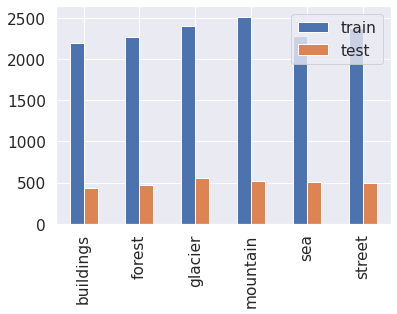

In [ ]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

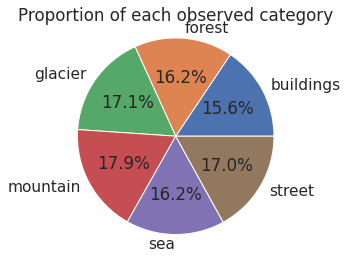

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0), 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## Visualize the data 

In [ ]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

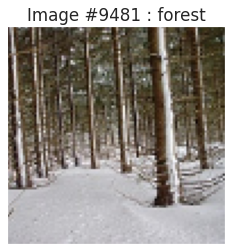

In [ ]:
display_random_image(class_names, train_data, train_labels)

In [ ]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

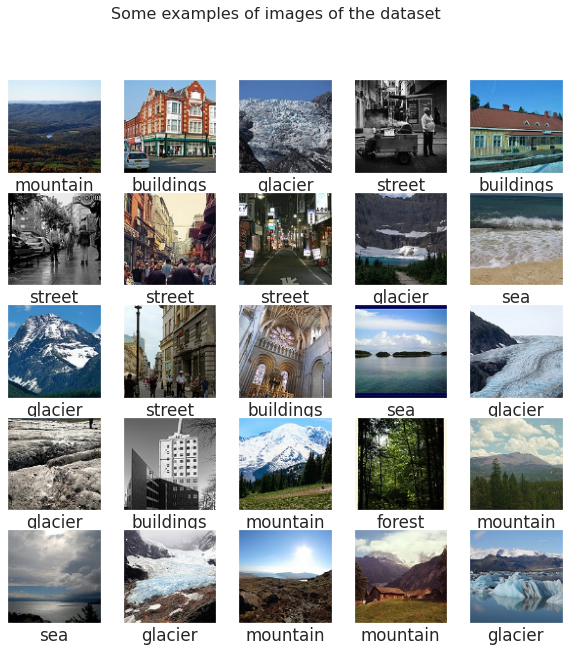

In [ ]:
display_examples(class_names, train_data, train_labels)

# Create, train, evaluate basic models

## FCNN (model_FCNN)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_FCNN = Sequential([
  Flatten(),
  Dense(100),
  Activation('relu'),
  Dense(50),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_FCNN.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_FCNN = model_FCNN.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 8s 8ms/step - loss: 1.7549 - accuracy: 0.4062 - val_loss: 1.3368 - val_accuracy: 0.5012
Epoch 2/8
351/351 [==============================] - 2s 5ms/step - loss: 1.3700 - accuracy: 0.4802 - val_loss: 1.3125 - val_accuracy: 0.5084
Epoch 3/8
351/351 [==============================] - 2s 5ms/step - loss: 1.2854 - accuracy: 0.5023 - val_loss: 1.2067 - val_accuracy: 0.5461
Epoch 4/8
351/351 [==============================] - 2s 5ms/step - loss: 1.2182 - accuracy: 0.5331 - val_loss: 1.1799 - val_accuracy: 0.5486
Epoch 5/8
351/351 [==============================] - 2s 5ms/step - loss: 1.1778 - accuracy: 0.5497 - val_loss: 1.2050 - val_accuracy: 0.5468
Epoch 6/8
351/351 [==============================] - 2s 5ms/step - loss: 1.1410 - accuracy: 0.5677 - val_loss: 1.3762 - val_accuracy: 0.4913
Epoch 7/8
351/351 [==============================] - 2s 6ms/step - loss: 1.1182 - accuracy: 0.5761 - val_loss: 1.2590 - val_accuracy: 0.5294
Epoch 8/8
351

In [ ]:
model_FCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 100)               2764900   
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 activation_1 (Activation)   (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 306       
                                                                 
 activation_2 (Activation)   (None, 6)                 0

In [ ]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(8)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

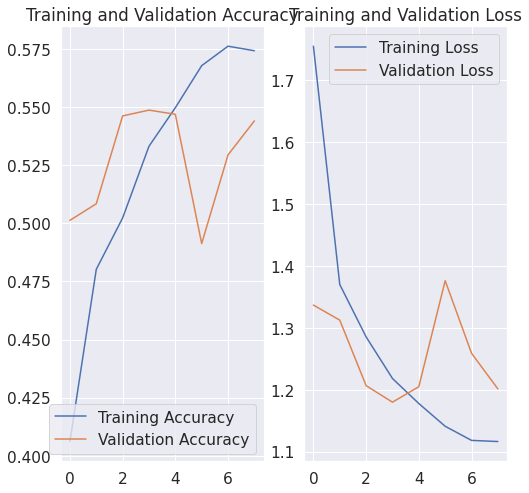

In [ ]:
plot_accuracy_loss(history_FCNN)

In [ ]:
test_loss = model_FCNN.evaluate(test_data, test_labels)

94/94 [==============================] - 0s 4ms/step - loss: 1.2616 - accuracy: 0.5220


## CNN (model_1)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_1 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_1 = model_1.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 12s 11ms/step - loss: 1.0236 - accuracy: 0.6011 - val_loss: 0.7475 - val_accuracy: 0.7225
Epoch 2/8
351/351 [==============================] - 3s 8ms/step - loss: 0.7144 - accuracy: 0.7359 - val_loss: 0.6030 - val_accuracy: 0.7770
Epoch 3/8
351/351 [==============================] - 3s 9ms/step - loss: 0.5794 - accuracy: 0.7896 - val_loss: 0.5954 - val_accuracy: 0.7802
Epoch 4/8
351/351 [==============================] - 3s 9ms/step - loss: 0.4679 - accuracy: 0.8291 - val_loss: 0.5232 - val_accuracy: 0.8094
Epoch 5/8
351/351 [==============================] - 3s 8ms/step - loss: 0.3671 - accuracy: 0.8699 - val_loss: 0.5605 - val_accuracy: 0.7941
Epoch 6/8
351/351 [==============================] - 4s 10ms/step - loss: 0.2712 - accuracy: 0.9027 - val_loss: 0.6281 - val_accuracy: 0.8023
Epoch 7/8
351/351 [==============================] - 3s 10ms/step - loss: 0.2028 - accuracy: 0.9283 - val_loss: 0.6235 - val_accuracy: 0.8080
Epoch 8/8

In [ ]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 activation_3 (Activation)   (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 activation_4 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                  

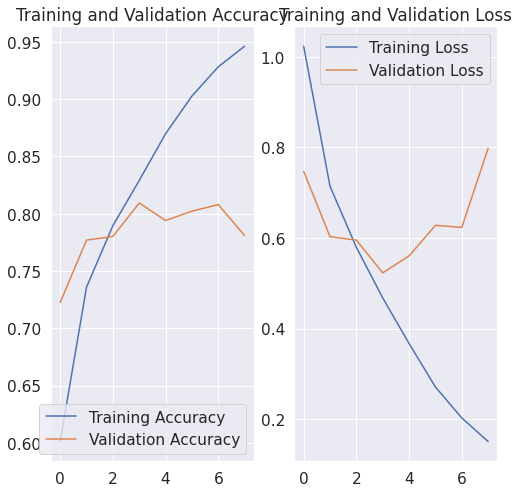

In [ ]:
plot_accuracy_loss(history_1)

In [ ]:
test_loss = model_1.evaluate(test_data, test_labels)

94/94 [==============================] - 1s 6ms/step - loss: 0.8823 - accuracy: 0.7547


# Different activation functions & optimizers, Learning scheduler based on model_2

## LeakyReLU (model_9)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_9 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  LeakyReLU(alpha=0.2),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  LeakyReLU(alpha=0.2),
  Dense(120),
  LeakyReLU(alpha=0.2),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_9.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_9 = model_9.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 16s 13ms/step - loss: 1.0367 - accuracy: 0.5940 - val_loss: 0.8013 - val_accuracy: 0.7075
Epoch 2/8
351/351 [==============================] - 4s 10ms/step - loss: 0.7313 - accuracy: 0.7290 - val_loss: 0.7082 - val_accuracy: 0.7235
Epoch 3/8
351/351 [==============================] - 3s 9ms/step - loss: 0.5857 - accuracy: 0.7865 - val_loss: 0.6254 - val_accuracy: 0.7820
Epoch 4/8
351/351 [==============================] - 4s 10ms/step - loss: 0.4801 - accuracy: 0.8268 - val_loss: 0.6091 - val_accuracy: 0.7731
Epoch 5/8
351/351 [==============================] - 4s 11ms/step - loss: 0.3935 - accuracy: 0.8556 - val_loss: 0.6441 - val_accuracy: 0.7980
Epoch 6/8
351/351 [==============================] - 4s 10ms/step - loss: 0.3061 - accuracy: 0.8891 - val_loss: 0.6370 - val_accuracy: 0.8076
Epoch 7/8
351/351 [==============================] - 3s 10ms/step - loss: 0.2418 - accuracy: 0.9106 - val_loss: 0.6332 - val_accuracy: 0.8055
Epoch 

In [ ]:
plot_accuracy_loss(history_9)

NameError: ignored

## Swish (model_11)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_11 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('swish'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('swish'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('swish'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('swish'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('swish'),
  Dense(120),
  Activation('swish'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_11.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_11 = model_11.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 7s 15ms/step - loss: 1.0361 - accuracy: 0.5901 - val_loss: 0.8602 - val_accuracy: 0.6722
Epoch 2/8
351/351 [==============================] - 5s 13ms/step - loss: 0.7937 - accuracy: 0.6941 - val_loss: 0.7539 - val_accuracy: 0.7132
Epoch 3/8
351/351 [==============================] - 4s 12ms/step - loss: 0.6785 - accuracy: 0.7427 - val_loss: 0.6927 - val_accuracy: 0.7524
Epoch 4/8
351/351 [==============================] - 5s 13ms/step - loss: 0.6037 - accuracy: 0.7718 - val_loss: 0.6652 - val_accuracy: 0.7620
Epoch 5/8
351/351 [==============================] - 5s 14ms/step - loss: 0.5067 - accuracy: 0.8138 - val_loss: 0.6122 - val_accuracy: 0.7823
Epoch 6/8
351/351 [==============================] - 4s 13ms/step - loss: 0.4177 - accuracy: 0.8456 - val_loss: 0.6454 - val_accuracy: 0.7788
Epoch 7/8
351/351 [==============================] - 4s 12ms/step - loss: 0.3491 - accuracy: 0.8718 - val_loss: 0.6991 - val_accuracy: 0.7738
Epoch 

In [ ]:
plot_accuracy_loss(history_11)

NameError: ignored

## Adagrad (model_6)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_6 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_6.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adagrad(),
                metrics=["accuracy"])

In [ ]:
history_6 = model_6.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 7s 13ms/step - loss: 1.7714 - accuracy: 0.2376 - val_loss: 1.7388 - val_accuracy: 0.2882
Epoch 2/8
351/351 [==============================] - 3s 9ms/step - loss: 1.6303 - accuracy: 0.3972 - val_loss: 1.4631 - val_accuracy: 0.4361
Epoch 3/8
351/351 [==============================] - 3s 10ms/step - loss: 1.2970 - accuracy: 0.5110 - val_loss: 1.2454 - val_accuracy: 0.5162
Epoch 4/8
351/351 [==============================] - 3s 9ms/step - loss: 1.1776 - accuracy: 0.5449 - val_loss: 1.1854 - val_accuracy: 0.5372
Epoch 5/8
351/351 [==============================] - 4s 11ms/step - loss: 1.1257 - accuracy: 0.5646 - val_loss: 1.1422 - val_accuracy: 0.5461
Epoch 6/8
351/351 [==============================] - 3s 9ms/step - loss: 1.0888 - accuracy: 0.5777 - val_loss: 1.1191 - val_accuracy: 0.5618
Epoch 7/8
351/351 [==============================] - 3s 9ms/step - loss: 1.0602 - accuracy: 0.5906 - val_loss: 1.0807 - val_accuracy: 0.5800
Epoch 8/8


In [ ]:
plot_accuracy_loss(history_6)

NameError: ignored

## SGD (model_7)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_7 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_7.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["accuracy"])

In [ ]:
history_7 = model_7.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 6s 14ms/step - loss: 1.5962 - accuracy: 0.3598 - val_loss: 2.0525 - val_accuracy: 0.2159
Epoch 2/8
351/351 [==============================] - 3s 9ms/step - loss: 1.1550 - accuracy: 0.5508 - val_loss: 1.0366 - val_accuracy: 0.5832
Epoch 3/8
351/351 [==============================] - 3s 9ms/step - loss: 1.0149 - accuracy: 0.5991 - val_loss: 1.0083 - val_accuracy: 0.6128
Epoch 4/8
351/351 [==============================] - 3s 10ms/step - loss: 0.9553 - accuracy: 0.6298 - val_loss: 0.9404 - val_accuracy: 0.6395
Epoch 5/8
351/351 [==============================] - 4s 10ms/step - loss: 0.9138 - accuracy: 0.6480 - val_loss: 0.9000 - val_accuracy: 0.6395
Epoch 6/8
351/351 [==============================] - 3s 10ms/step - loss: 0.8730 - accuracy: 0.6612 - val_loss: 0.9667 - val_accuracy: 0.6185
Epoch 7/8
351/351 [==============================] - 3s 10ms/step - loss: 0.8377 - accuracy: 0.6757 - val_loss: 0.8187 - val_accuracy: 0.6893
Epoch 8/

In [ ]:
plot_accuracy_loss(history_7)

NameError: ignored

## RMSProp (model_8)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_8 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_8.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.RMSprop(),
                metrics=["accuracy"])

In [ ]:
history_8 = model_8.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 15s 12ms/step - loss: 1.1174 - accuracy: 0.5584 - val_loss: 0.9475 - val_accuracy: 0.6274
Epoch 2/8
351/351 [==============================] - 3s 10ms/step - loss: 0.8126 - accuracy: 0.6921 - val_loss: 0.7807 - val_accuracy: 0.6975
Epoch 3/8
351/351 [==============================] - 3s 10ms/step - loss: 0.6628 - accuracy: 0.7541 - val_loss: 0.6290 - val_accuracy: 0.7716
Epoch 4/8
351/351 [==============================] - 3s 10ms/step - loss: 0.5701 - accuracy: 0.7957 - val_loss: 0.5477 - val_accuracy: 0.8083
Epoch 5/8
351/351 [==============================] - 4s 10ms/step - loss: 0.4845 - accuracy: 0.8240 - val_loss: 0.5409 - val_accuracy: 0.8204
Epoch 6/8
351/351 [==============================] - 3s 9ms/step - loss: 0.4266 - accuracy: 0.8497 - val_loss: 0.7159 - val_accuracy: 0.7574
Epoch 7/8
351/351 [==============================] - 3s 10ms/step - loss: 0.3595 - accuracy: 0.8705 - val_loss: 0.6922 - val_accuracy: 0.7862
Epoch 

In [ ]:
plot_accuracy_loss(history_8)

## ReLU & Adam (model_10)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_10 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_10.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_10 = model_10.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 7s 13ms/step - loss: 1.0275 - accuracy: 0.5948 - val_loss: 0.8344 - val_accuracy: 0.6833
Epoch 2/8
351/351 [==============================] - 3s 9ms/step - loss: 0.7211 - accuracy: 0.7284 - val_loss: 0.6493 - val_accuracy: 0.7524
Epoch 3/8
351/351 [==============================] - 3s 10ms/step - loss: 0.5700 - accuracy: 0.7928 - val_loss: 0.5771 - val_accuracy: 0.7941
Epoch 4/8
351/351 [==============================] - 4s 10ms/step - loss: 0.4935 - accuracy: 0.8231 - val_loss: 0.5069 - val_accuracy: 0.8176
Epoch 5/8
351/351 [==============================] - 5s 14ms/step - loss: 0.4282 - accuracy: 0.8439 - val_loss: 0.5126 - val_accuracy: 0.8272
Epoch 6/8
351/351 [==============================] - 3s 10ms/step - loss: 0.3546 - accuracy: 0.8732 - val_loss: 0.5382 - val_accuracy: 0.8108
Epoch 7/8
351/351 [==============================] - 3s 9ms/step - loss: 0.3071 - accuracy: 0.8891 - val_loss: 0.5375 - val_accuracy: 0.8304
Epoch 8/

In [ ]:
plot_accuracy_loss(history_10)

## lrs over loss 1e-4 (model_2)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_2 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Create the learning rate callback
lr_scheduler_2 = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch/20))

In [ ]:
history_2 = model_2.fit(train_data, train_labels, batch_size=32, epochs=80, validation_split = 0.2, callbacks=[lr_scheduler_2])

Epoch 1/80
351/351 [==============================] - 13s 12ms/step - loss: 1.7189 - accuracy: 0.3521 - val_loss: 1.5476 - val_accuracy: 0.4788 - lr: 1.0000e-05
Epoch 2/80
351/351 [==============================] - 3s 10ms/step - loss: 1.2781 - accuracy: 0.5313 - val_loss: 1.1595 - val_accuracy: 0.5312 - lr: 1.1220e-05
Epoch 3/80
351/351 [==============================] - 4s 10ms/step - loss: 1.0902 - accuracy: 0.5799 - val_loss: 1.0943 - val_accuracy: 0.5632 - lr: 1.2589e-05
Epoch 4/80
351/351 [==============================] - 3s 9ms/step - loss: 1.0290 - accuracy: 0.6037 - val_loss: 1.0354 - val_accuracy: 0.6053 - lr: 1.4125e-05
Epoch 5/80
351/351 [==============================] - 3s 10ms/step - loss: 0.9885 - accuracy: 0.6196 - val_loss: 0.9971 - val_accuracy: 0.6067 - lr: 1.5849e-05
Epoch 6/80
351/351 [==============================] - 3s 10ms/step - loss: 0.9552 - accuracy: 0.6329 - val_loss: 0.9647 - val_accuracy: 0.6274 - lr: 1.7783e-05
Epoch 7/80
351/351 [====================

Text(0.5, 1.0, 'Finding the ideal learning rate')

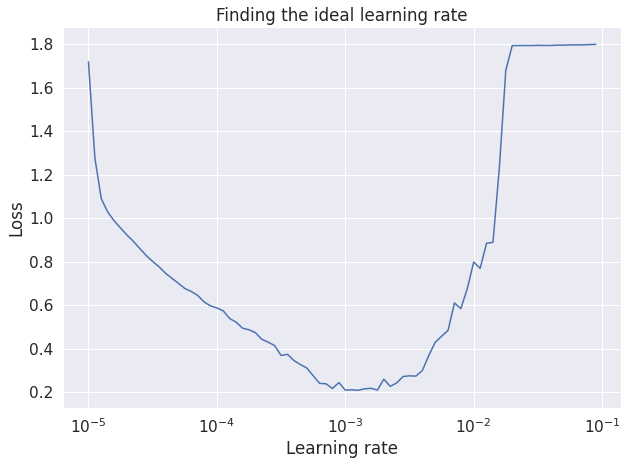

In [ ]:
# Plot the learning rate decay curve
import numpy as np
import matplotlib.pyplot as plt

lrs = 1e-5 * (10**(tf.range(80)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history_2.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate")

In [ ]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(80)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

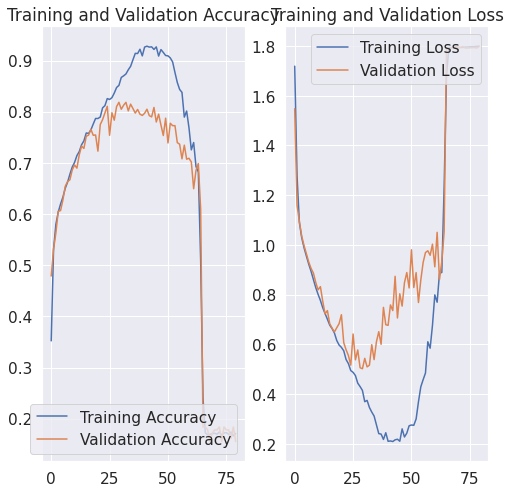

In [ ]:
plot_accuracy_loss(history_2)

## trying lrs (model_3)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_3 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_3 = model_3.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 9s 14ms/step - loss: 1.0759 - accuracy: 0.5705 - val_loss: 0.7826 - val_accuracy: 0.7079
Epoch 2/8
351/351 [==============================] - 3s 9ms/step - loss: 0.7347 - accuracy: 0.7248 - val_loss: 0.6514 - val_accuracy: 0.7667
Epoch 3/8
351/351 [==============================] - 3s 9ms/step - loss: 0.6239 - accuracy: 0.7730 - val_loss: 0.6448 - val_accuracy: 0.7649
Epoch 4/8
351/351 [==============================] - 4s 10ms/step - loss: 0.5394 - accuracy: 0.8043 - val_loss: 0.6819 - val_accuracy: 0.7563
Epoch 5/8
351/351 [==============================] - 4s 10ms/step - loss: 0.4678 - accuracy: 0.8309 - val_loss: 0.5773 - val_accuracy: 0.7916
Epoch 6/8
351/351 [==============================] - 3s 9ms/step - loss: 0.4003 - accuracy: 0.8552 - val_loss: 0.5219 - val_accuracy: 0.8144
Epoch 7/8
351/351 [==============================] - 3s 9ms/step - loss: 0.3608 - accuracy: 0.8706 - val_loss: 0.5360 - val_accuracy: 0.8133
Epoch 8/8


In [ ]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(8)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

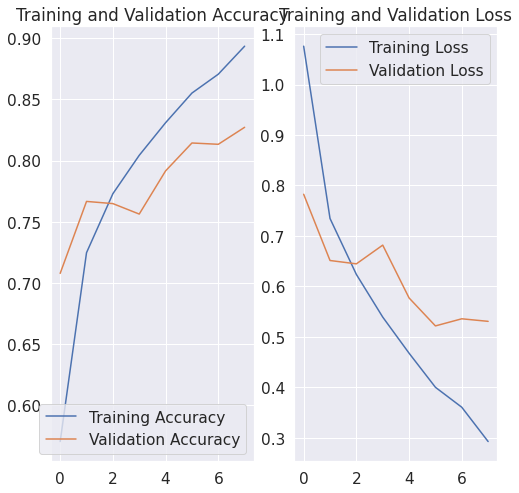

In [ ]:
plot_accuracy_loss(history_3)

## trying lrs (model_4)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_4 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 8e-4),
                metrics=["accuracy"])

In [ ]:
history_4 = model_4.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 9s 13ms/step - loss: 1.0395 - accuracy: 0.5896 - val_loss: 0.9183 - val_accuracy: 0.6420
Epoch 2/8
351/351 [==============================] - 3s 10ms/step - loss: 0.7567 - accuracy: 0.7173 - val_loss: 0.7034 - val_accuracy: 0.7392
Epoch 3/8
351/351 [==============================] - 3s 9ms/step - loss: 0.6179 - accuracy: 0.7698 - val_loss: 0.5925 - val_accuracy: 0.7827
Epoch 4/8
351/351 [==============================] - 3s 10ms/step - loss: 0.5260 - accuracy: 0.8097 - val_loss: 0.5168 - val_accuracy: 0.8183
Epoch 5/8
351/351 [==============================] - 5s 13ms/step - loss: 0.4558 - accuracy: 0.8334 - val_loss: 0.5229 - val_accuracy: 0.8151
Epoch 6/8
351/351 [==============================] - 3s 10ms/step - loss: 0.3967 - accuracy: 0.8582 - val_loss: 0.5060 - val_accuracy: 0.8204
Epoch 7/8
351/351 [==============================] - 3s 9ms/step - loss: 0.3472 - accuracy: 0.8787 - val_loss: 0.6591 - val_accuracy: 0.7905
Epoch 8/

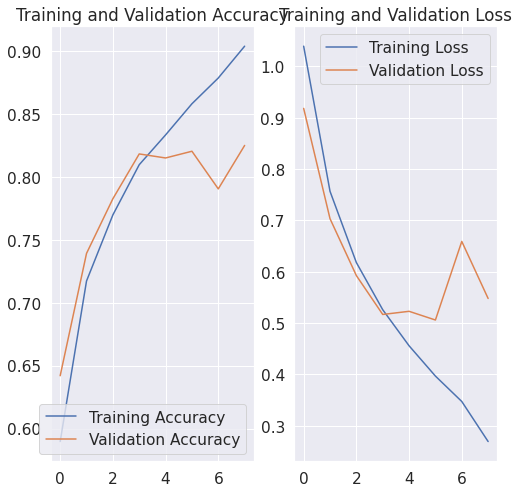

In [ ]:
plot_accuracy_loss(history_4)

## trying lrs (model_5)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_5 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_5.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-4),
                metrics=["accuracy"])

In [ ]:
history_5 = model_5.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 7s 13ms/step - loss: 1.0523 - accuracy: 0.5875 - val_loss: 0.8784 - val_accuracy: 0.6758
Epoch 2/8
351/351 [==============================] - 3s 9ms/step - loss: 0.7565 - accuracy: 0.7184 - val_loss: 0.7233 - val_accuracy: 0.7250
Epoch 3/8
351/351 [==============================] - 4s 10ms/step - loss: 0.6419 - accuracy: 0.7650 - val_loss: 0.6846 - val_accuracy: 0.7485
Epoch 4/8
351/351 [==============================] - 4s 11ms/step - loss: 0.5677 - accuracy: 0.7970 - val_loss: 0.6070 - val_accuracy: 0.7716
Epoch 5/8
351/351 [==============================] - 3s 9ms/step - loss: 0.4969 - accuracy: 0.8216 - val_loss: 0.6470 - val_accuracy: 0.7763
Epoch 6/8
351/351 [==============================] - 4s 10ms/step - loss: 0.4302 - accuracy: 0.8457 - val_loss: 0.4951 - val_accuracy: 0.8237
Epoch 7/8
351/351 [==============================] - 4s 10ms/step - loss: 0.3910 - accuracy: 0.8597 - val_loss: 0.5341 - val_accuracy: 0.8069
Epoch 8/

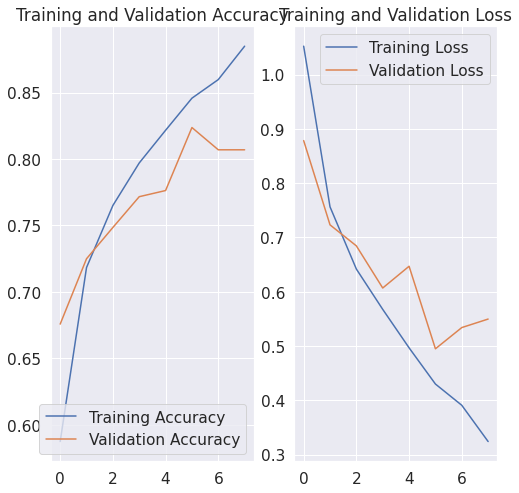

In [ ]:
plot_accuracy_loss(history_5)

# Data augmentation based on model_1

## Data augmentation (model_2) -|***|-

In [ ]:
# Set the random seed
tf.random.set_seed(42)

data_augmentation = Sequential([
#  RandomBrightness(0.1, input_shape=INPUT_TENSOR),
#  RandomContrast(0.1),
  RandomFlip("horizontal"),
  RandomRotation(0.05),
#  RandomZoom(0.05),
])

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_2 = Sequential([
  data_augmentation,
  Conv2D(16, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_2 = model_2.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8


351/351 [==============================] - 31s 77ms/step - loss: 1.0532 - accuracy: 0.5862 - val_loss: 0.8367 - val_accuracy: 0.6797
Epoch 2/8
351/351 [==============================] - 27s 76ms/step - loss: 0.7710 - accuracy: 0.7143 - val_loss: 0.7213 - val_accuracy: 0.7161
Epoch 3/8
351/351 [==============================] - 27s 76ms/step - loss: 0.6695 - accuracy: 0.7560 - val_loss: 0.7315 - val_accuracy: 0.7175
Epoch 4/8
351/351 [==============================] - 27s 76ms/step - loss: 0.5968 - accuracy: 0.7841 - val_loss: 0.5454 - val_accuracy: 0.8012
Epoch 5/8
351/351 [==============================] - 26s 74ms/step - loss: 0.5455 - accuracy: 0.8003 - val_loss: 0.6231 - val_accuracy: 0.7727
Epoch 6/8
351/351 [==============================] - 26s 73ms/step - loss: 0.4941 - accuracy: 0.8227 - val_loss: 0.6118 - val_accuracy: 0.7706
Epoch 7/8
351/351 [==============================] - 26s 74ms/step - loss: 0.4633 - accuracy: 0.8339 - val_loss: 0.4940 - val_accuracy: 0.8212
Epoch 8/8

You can see each epoch takes longer than the previous model. This is because our data is being augmented on the fly on the CPU as it gets loaded onto the GPU, in turn, increasing the amount of time between each epoch.

In [ ]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 activation_8 (Activation)   (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 activation_9 (Activation)   (None, 48, 48, 32)        0         
                                                      

That's looking much better, the loss curves are much closer to each other. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

## Data augmentation (model_3)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

data_augmentati = Sequential([
#  RandomBrightness(0.1, input_shape=INPUT_TENSOR),
#  RandomContrast(0.1),
  RandomFlip("horizontal"),
  RandomRotation(0.05),
  RandomZoom(0.05),
])

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_3 = Sequential([
  data_augmentati,
  Conv2D(16, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_3 = model_3.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8


351/351 [==============================] - 52s 130ms/step - loss: 1.0747 - accuracy: 0.5805 - val_loss: 0.9550 - val_accuracy: 0.6462
Epoch 2/8
351/351 [==============================] - 44s 124ms/step - loss: 0.7809 - accuracy: 0.7104 - val_loss: 0.7285 - val_accuracy: 0.7203
Epoch 3/8
351/351 [==============================] - 44s 127ms/step - loss: 0.6761 - accuracy: 0.7498 - val_loss: 0.6637 - val_accuracy: 0.7599
Epoch 4/8
351/351 [==============================] - 43s 123ms/step - loss: 0.5916 - accuracy: 0.7863 - val_loss: 0.7103 - val_accuracy: 0.7399
Epoch 5/8
351/351 [==============================] - 45s 128ms/step - loss: 0.5395 - accuracy: 0.8033 - val_loss: 0.6349 - val_accuracy: 0.7838
Epoch 6/8
351/351 [==============================] - 44s 124ms/step - loss: 0.4928 - accuracy: 0.8211 - val_loss: 0.6285 - val_accuracy: 0.7763
Epoch 7/8
351/351 [==============================] - 43s 124ms/step - loss: 0.4611 - accuracy: 0.8321 - val_loss: 0.5505 - val_accuracy: 0.8101
Ep

You can see each epoch takes longer than the previous model. This is because our data is being augmented on the fly on the CPU as it gets loaded onto the GPU, in turn, increasing the amount of time between each epoch.

In [ ]:
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 activation_13 (Activation)  (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 activation_14 (Activation)  (None, 48, 48, 32)        0         
                                                      

That's looking much better, the loss curves are much closer to each other. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

## Data augmentation (model_4)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

data_augmenta = Sequential([
#  RandomBrightness(0.1, input_shape=INPUT_TENSOR),
  RandomContrast(0.1),
  RandomFlip("horizontal"),
  RandomRotation(0.05),
  RandomZoom(0.05),
])

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_4 = Sequential([
  data_augmenta,
  Conv2D(16, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_4 = model_4.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8


351/351 [==============================] - 85s 220ms/step - loss: 1.0789 - accuracy: 0.5750 - val_loss: 1.1798 - val_accuracy: 0.6060
Epoch 2/8
351/351 [==============================] - 83s 238ms/step - loss: 0.7974 - accuracy: 0.6995 - val_loss: 0.7899 - val_accuracy: 0.7129
Epoch 3/8
351/351 [==============================] - 77s 219ms/step - loss: 0.6973 - accuracy: 0.7422 - val_loss: 0.7046 - val_accuracy: 0.7396
Epoch 4/8
351/351 [==============================] - 77s 220ms/step - loss: 0.6135 - accuracy: 0.7762 - val_loss: 0.5504 - val_accuracy: 0.8012
Epoch 5/8
351/351 [==============================] - 78s 221ms/step - loss: 0.5604 - accuracy: 0.7932 - val_loss: 0.8319 - val_accuracy: 0.7186
Epoch 6/8
351/351 [==============================] - 76s 218ms/step - loss: 0.5175 - accuracy: 0.8124 - val_loss: 0.6398 - val_accuracy: 0.7681
Epoch 7/8
351/351 [==============================] - 78s 221ms/step - loss: 0.4678 - accuracy: 0.8322 - val_loss: 0.5721 - val_accuracy: 0.8030
Ep

You can see each epoch takes longer than the previous model. This is because our data is being augmented on the fly on the CPU as it gets loaded onto the GPU, in turn, increasing the amount of time between each epoch.

In [ ]:
model_4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 activation_18 (Activation)  (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 activation_19 (Activation)  (None, 48, 48, 32)        0         
                                                      

That's looking much better, the loss curves are much closer to each other. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

## Data augmentation (model_5)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

data_augment = Sequential([
  RandomBrightness(0.1, input_shape=INPUT_TENSOR),
  RandomContrast(0.1),
  RandomFlip("horizontal"),
  RandomRotation(0.05),
  RandomZoom(0.05),
])

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_5 = Sequential([
  data_augment,
  Conv2D(16, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_5.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_5 = model_5.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8


351/351 [==============================] - 101s 270ms/step - loss: 1.9021 - accuracy: 0.1774 - val_loss: 1.7897 - val_accuracy: 0.2098
Epoch 2/8
351/351 [==============================] - 94s 267ms/step - loss: 1.7938 - accuracy: 0.1723 - val_loss: 1.7905 - val_accuracy: 0.1860
Epoch 3/8
351/351 [==============================] - 95s 270ms/step - loss: 1.7948 - accuracy: 0.1746 - val_loss: 1.7903 - val_accuracy: 0.1877
Epoch 4/8
351/351 [==============================] - 92s 262ms/step - loss: 1.7917 - accuracy: 0.1751 - val_loss: 1.7904 - val_accuracy: 0.1874
Epoch 5/8
351/351 [==============================] - 94s 268ms/step - loss: 1.7911 - accuracy: 0.1750 - val_loss: 1.7906 - val_accuracy: 0.1838
Epoch 6/8
351/351 [==============================] - 94s 269ms/step - loss: 1.7911 - accuracy: 0.1778 - val_loss: 1.7904 - val_accuracy: 0.1849
Epoch 7/8
351/351 [==============================] - 92s 263ms/step - loss: 1.7912 - accuracy: 0.1784 - val_loss: 1.7907 - val_accuracy: 0.1842
E

You can see each epoch takes longer than the previous model. This is because our data is being augmented on the fly on the CPU as it gets loaded onto the GPU, in turn, increasing the amount of time between each epoch.

In [ ]:
model_5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 activation_23 (Activation)  (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 activation_24 (Activation)  (None, 48, 48, 32)        0         
                                                      

That's looking much better, the loss curves are much closer to each other. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

## Data augmentation (model_6)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

data_augm = Sequential([
  RandomBrightness(0.1),
  RandomContrast(0.1),
  RandomFlip("horizontal"),
  RandomRotation(0.05),
  RandomZoom(0.05),
])

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_6 = Sequential([
  data_augm,
  Conv2D(16, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_6.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_6 = model_6.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8


351/351 [==============================] - 102s 266ms/step - loss: 1.9081 - accuracy: 0.1745 - val_loss: 1.7708 - val_accuracy: 0.2173
Epoch 2/8
351/351 [==============================] - 93s 264ms/step - loss: 1.7955 - accuracy: 0.1696 - val_loss: 1.7903 - val_accuracy: 0.1685
Epoch 3/8
351/351 [==============================] - 93s 264ms/step - loss: 1.7916 - accuracy: 0.1737 - val_loss: 1.7891 - val_accuracy: 0.1842
Epoch 4/8
351/351 [==============================] - 93s 264ms/step - loss: 1.7913 - accuracy: 0.1774 - val_loss: 1.7875 - val_accuracy: 0.1924
Epoch 5/8
351/351 [==============================] - 93s 265ms/step - loss: 1.7912 - accuracy: 0.1742 - val_loss: 1.7785 - val_accuracy: 0.2177
Epoch 6/8
 17/351 [>.............................] - ETA: 1:35 - loss: 1.7908 - accuracy: 0.1654

KeyboardInterrupt: ignored

You can see each epoch takes longer than the previous model. This is because our data is being augmented on the fly on the CPU as it gets loaded onto the GPU, in turn, increasing the amount of time between each epoch.

In [ ]:
model_6.summary()

That's looking much better, the loss curves are much closer to each other. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

# Dropout based on model_1

## Dropout (model_6)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_6 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.1),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.1),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.1),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_6.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_6 = model_6.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 7s 12ms/step - loss: 1.1047 - accuracy: 0.5650 - val_loss: 0.8565 - val_accuracy: 0.6765
Epoch 2/8
351/351 [==============================] - 4s 11ms/step - loss: 0.7703 - accuracy: 0.7132 - val_loss: 0.8108 - val_accuracy: 0.6897
Epoch 3/8
351/351 [==============================] - 4s 11ms/step - loss: 0.6347 - accuracy: 0.7649 - val_loss: 0.6168 - val_accuracy: 0.7684
Epoch 4/8
351/351 [==============================] - 4s 11ms/step - loss: 0.5606 - accuracy: 0.7972 - val_loss: 0.5576 - val_accuracy: 0.8009
Epoch 5/8
351/351 [==============================] - 4s 10ms/step - loss: 0.4914 - accuracy: 0.8203 - val_loss: 0.5970 - val_accuracy: 0.7795
Epoch 6/8
351/351 [==============================] - 4s 11ms/step - loss: 0.4366 - accuracy: 0.8410 - val_loss: 0.5420 - val_accuracy: 0.8123
Epoch 7/8
351/351 [==============================] - 4s 10ms/step - loss: 0.3831 - accuracy: 0.8602 - val_loss: 0.5403 - val_accuracy: 0.8083
Epoch 

## Dropout (model_7)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_7 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.15),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.15),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.15),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_7.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_7 = model_7.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 16s 13ms/step - loss: 1.0922 - accuracy: 0.5711 - val_loss: 0.8867 - val_accuracy: 0.6612
Epoch 2/8
351/351 [==============================] - 4s 11ms/step - loss: 0.7924 - accuracy: 0.7027 - val_loss: 0.6508 - val_accuracy: 0.7642
Epoch 3/8
351/351 [==============================] - 4s 11ms/step - loss: 0.6287 - accuracy: 0.7691 - val_loss: 0.6288 - val_accuracy: 0.7610
Epoch 4/8
351/351 [==============================] - 3s 10ms/step - loss: 0.5236 - accuracy: 0.8088 - val_loss: 0.5588 - val_accuracy: 0.7955
Epoch 5/8
351/351 [==============================] - 3s 10ms/step - loss: 0.4548 - accuracy: 0.8331 - val_loss: 0.5369 - val_accuracy: 0.8119
Epoch 6/8
351/351 [==============================] - 4s 11ms/step - loss: 0.3849 - accuracy: 0.8608 - val_loss: 0.5518 - val_accuracy: 0.8023
Epoch 7/8
351/351 [==============================] - 4s 10ms/step - loss: 0.3263 - accuracy: 0.8802 - val_loss: 0.5404 - val_accuracy: 0.8140
Epoch

## Dropout (model_5)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_5 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.2),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.2),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.2),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_5.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_5 = model_5.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 6s 12ms/step - loss: 1.1002 - accuracy: 0.5643 - val_loss: 0.8791 - val_accuracy: 0.6694
Epoch 2/8
351/351 [==============================] - 4s 10ms/step - loss: 0.8015 - accuracy: 0.6964 - val_loss: 0.6840 - val_accuracy: 0.7524
Epoch 3/8
351/351 [==============================] - 4s 12ms/step - loss: 0.6560 - accuracy: 0.7548 - val_loss: 0.6260 - val_accuracy: 0.7748
Epoch 4/8
351/351 [==============================] - 4s 10ms/step - loss: 0.5710 - accuracy: 0.7904 - val_loss: 0.6181 - val_accuracy: 0.7674
Epoch 5/8
351/351 [==============================] - 4s 11ms/step - loss: 0.4892 - accuracy: 0.8185 - val_loss: 0.5275 - val_accuracy: 0.8101
Epoch 6/8
351/351 [==============================] - 4s 11ms/step - loss: 0.4183 - accuracy: 0.8451 - val_loss: 0.5691 - val_accuracy: 0.7944
Epoch 7/8
351/351 [==============================] - 4s 11ms/step - loss: 0.3745 - accuracy: 0.8615 - val_loss: 0.5580 - val_accuracy: 0.8055
Epoch 

## Dropout (model_8)      -|***|-

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_8 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.25),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.25),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.25),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_8.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_8 = model_8.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 9s 17ms/step - loss: 1.1419 - accuracy: 0.5509 - val_loss: 0.9045 - val_accuracy: 0.6605
Epoch 2/8
351/351 [==============================] - 4s 11ms/step - loss: 0.8573 - accuracy: 0.6743 - val_loss: 0.7598 - val_accuracy: 0.7325
Epoch 3/8
351/351 [==============================] - 3s 10ms/step - loss: 0.7225 - accuracy: 0.7335 - val_loss: 0.7337 - val_accuracy: 0.7314
Epoch 4/8
351/351 [==============================] - 3s 10ms/step - loss: 0.6119 - accuracy: 0.7779 - val_loss: 0.6554 - val_accuracy: 0.7638
Epoch 5/8
351/351 [==============================] - 4s 11ms/step - loss: 0.5332 - accuracy: 0.8044 - val_loss: 0.5470 - val_accuracy: 0.8019
Epoch 6/8
351/351 [==============================] - 4s 11ms/step - loss: 0.4716 - accuracy: 0.8268 - val_loss: 0.5685 - val_accuracy: 0.7823
Epoch 7/8
351/351 [==============================] - 4s 11ms/step - loss: 0.4257 - accuracy: 0.8456 - val_loss: 0.5297 - val_accuracy: 0.8048
Epoch 

## Dropout (model_10)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_10 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.3),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.3),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.3),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_10.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_10 = model_10.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 6s 13ms/step - loss: 1.1977 - accuracy: 0.5219 - val_loss: 0.9683 - val_accuracy: 0.6256
Epoch 2/8
351/351 [==============================] - 4s 11ms/step - loss: 0.8303 - accuracy: 0.6866 - val_loss: 0.7355 - val_accuracy: 0.7200
Epoch 3/8
351/351 [==============================] - 4s 11ms/step - loss: 0.6952 - accuracy: 0.7410 - val_loss: 0.6935 - val_accuracy: 0.7396
Epoch 4/8
351/351 [==============================] - 4s 11ms/step - loss: 0.6023 - accuracy: 0.7762 - val_loss: 0.6083 - val_accuracy: 0.7745
Epoch 5/8
351/351 [==============================] - 4s 11ms/step - loss: 0.5369 - accuracy: 0.8017 - val_loss: 0.5687 - val_accuracy: 0.7930
Epoch 6/8
351/351 [==============================] - 3s 10ms/step - loss: 0.4765 - accuracy: 0.8269 - val_loss: 0.5745 - val_accuracy: 0.7880
Epoch 7/8
351/351 [==============================] - 3s 10ms/step - loss: 0.4430 - accuracy: 0.8384 - val_loss: 0.5558 - val_accuracy: 0.8026
Epoch 

## Dropout (model_9)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_9 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.35),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.35),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.35),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_9.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_9 = model_9.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 10s 20ms/step - loss: 1.1976 - accuracy: 0.5228 - val_loss: 1.0487 - val_accuracy: 0.6060
Epoch 2/8
351/351 [==============================] - 4s 12ms/step - loss: 0.8576 - accuracy: 0.6769 - val_loss: 0.7892 - val_accuracy: 0.7054
Epoch 3/8
351/351 [==============================] - 5s 15ms/step - loss: 0.7199 - accuracy: 0.7327 - val_loss: 0.7005 - val_accuracy: 0.7431
Epoch 4/8
351/351 [==============================] - 4s 12ms/step - loss: 0.6264 - accuracy: 0.7721 - val_loss: 0.6422 - val_accuracy: 0.7738
Epoch 5/8
351/351 [==============================] - 4s 10ms/step - loss: 0.5653 - accuracy: 0.7901 - val_loss: 0.6172 - val_accuracy: 0.7702
Epoch 6/8
351/351 [==============================] - 4s 11ms/step - loss: 0.5083 - accuracy: 0.8194 - val_loss: 0.6599 - val_accuracy: 0.7602
Epoch 7/8
351/351 [==============================] - 3s 10ms/step - loss: 0.4732 - accuracy: 0.8292 - val_loss: 0.5421 - val_accuracy: 0.8101
Epoch

## Dropout (model_4)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_4 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.4),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.4),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.4),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_4 = model_4.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 6s 13ms/step - loss: 1.1538 - accuracy: 0.5485 - val_loss: 0.9599 - val_accuracy: 0.6548
Epoch 2/8
351/351 [==============================] - 4s 11ms/step - loss: 0.8566 - accuracy: 0.6760 - val_loss: 0.7688 - val_accuracy: 0.7214
Epoch 3/8
351/351 [==============================] - 4s 10ms/step - loss: 0.7370 - accuracy: 0.7255 - val_loss: 0.7638 - val_accuracy: 0.7243
Epoch 4/8
351/351 [==============================] - 4s 10ms/step - loss: 0.6523 - accuracy: 0.7635 - val_loss: 0.6678 - val_accuracy: 0.7706
Epoch 5/8
351/351 [==============================] - 4s 11ms/step - loss: 0.5935 - accuracy: 0.7833 - val_loss: 0.6029 - val_accuracy: 0.7934
Epoch 6/8
351/351 [==============================] - 4s 10ms/step - loss: 0.5434 - accuracy: 0.8015 - val_loss: 0.6739 - val_accuracy: 0.7499
Epoch 7/8
351/351 [==============================] - 4s 10ms/step - loss: 0.4967 - accuracy: 0.8186 - val_loss: 0.5722 - val_accuracy: 0.7902
Epoch 

## Dropout (model_2)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_2 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.6),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.6),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.6),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_2 = model_2.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 16s 14ms/step - loss: 1.4052 - accuracy: 0.4336 - val_loss: 1.1606 - val_accuracy: 0.6053
Epoch 2/8
351/351 [==============================] - 4s 11ms/step - loss: 0.9579 - accuracy: 0.6326 - val_loss: 0.9585 - val_accuracy: 0.6854
Epoch 3/8
351/351 [==============================] - 4s 10ms/step - loss: 0.8379 - accuracy: 0.6826 - val_loss: 0.9030 - val_accuracy: 0.6943
Epoch 4/8
351/351 [==============================] - 4s 11ms/step - loss: 0.7465 - accuracy: 0.7218 - val_loss: 0.9015 - val_accuracy: 0.6612
Epoch 5/8
351/351 [==============================] - 4s 11ms/step - loss: 0.7047 - accuracy: 0.7374 - val_loss: 0.7955 - val_accuracy: 0.7257
Epoch 6/8
351/351 [==============================] - 4s 11ms/step - loss: 0.6515 - accuracy: 0.7685 - val_loss: 0.8158 - val_accuracy: 0.7029
Epoch 7/8
351/351 [==============================] - 4s 11ms/step - loss: 0.6241 - accuracy: 0.7660 - val_loss: 0.7531 - val_accuracy: 0.7289
Epoch

## Dropout (model_3)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_3 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.6),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.6),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.6),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dropout(0.6),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_3 = model_3.fit(train_data, train_labels, batch_size=32, epochs=8, validation_split = 0.2)

Epoch 1/8
351/351 [==============================] - 7s 13ms/step - loss: 1.4391 - accuracy: 0.4019 - val_loss: 1.2307 - val_accuracy: 0.5237
Epoch 2/8
351/351 [==============================] - 4s 12ms/step - loss: 1.1221 - accuracy: 0.5522 - val_loss: 1.1036 - val_accuracy: 0.6156
Epoch 3/8
351/351 [==============================] - 4s 11ms/step - loss: 1.0761 - accuracy: 0.5693 - val_loss: 1.0988 - val_accuracy: 0.5550
Epoch 4/8
351/351 [==============================] - 4s 10ms/step - loss: 1.0299 - accuracy: 0.5929 - val_loss: 1.0476 - val_accuracy: 0.6242
Epoch 5/8
351/351 [==============================] - 4s 11ms/step - loss: 0.9897 - accuracy: 0.6075 - val_loss: 0.9967 - val_accuracy: 0.6491
Epoch 6/8
351/351 [==============================] - 4s 11ms/step - loss: 0.9520 - accuracy: 0.6307 - val_loss: 1.0213 - val_accuracy: 0.6277
Epoch 7/8
351/351 [==============================] - 4s 11ms/step - loss: 0.9167 - accuracy: 0.6462 - val_loss: 0.9998 - val_accuracy: 0.6281
Epoch 